# DALI Data Challenge

## 1. Data Visualization

In [1]:
%matplotlib ipympl

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.dates as mdates
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib

In [2]:
# Setting Colors and Defaults 
lightblue='#8ecae6'
navy='#003049'
grey='#8d99ae'
red='#c1121f'
darkred='#38040e'

colors=['#FFFFFF', navy]
colors_theme = [darkred, red, lightblue, navy, grey]

cmap_navy = matplotlib.colors.LinearSegmentedColormap.from_list('Navys', colors=colors, N=256, gamma=1.0)

sns.set_style('white')
# plt.style.use('white')
sns.set_palette(colors_theme)

plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In this section I am importing the dataframe and adding a few columns of interest. For example, the day of the week, 

In [3]:
df = pd.read_csv('superstore.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df.sort_values(by='Order Date', inplace = True) 
df['Region'].unique()
df['Order Year-Month'] = df['Order Date'].map(lambda dt: dt.strftime('%Y-%m'))
# df['Week'] = df['Order Date'].dt.isocalendar().week
# df['Day of Week'] = df['Order Date'].day_name()
df['Order Year-Week'] = df['Order Date'].dt.strftime('%Y-%V')

df['date'] = pd.to_datetime(df['Order Date']) - pd.to_timedelta(7, unit='d')
# we use this data later when we find trends and make predictions
weekly_data = df.groupby([pd.Grouper(key='date', freq='W')])['Quantity'].sum()

weekday_list = []
for x in df['Order Date']:
    y = x.weekday()
    weekday_list.append(y)
    
df['Weekday'] = weekday_list

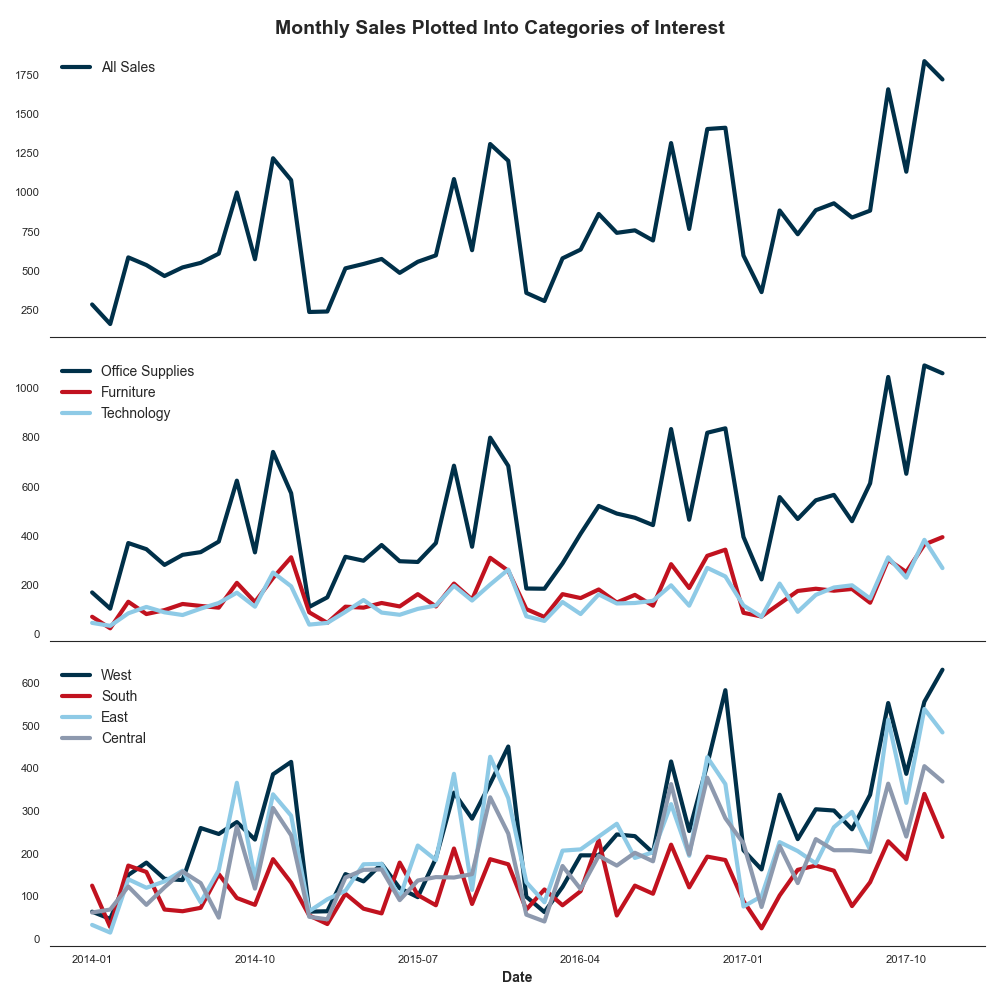

In [4]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,10))
fig.suptitle('Monthly Sales Plotted Into Categories of Interest', fontsize=14,  weight='bold')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))
axs[0].plot(df['Order Year-Month'].unique(), df.groupby('Order Year-Month')['Quantity'].aggregate('sum'), label='All Sales', color=navy, lw=3)  
axs[2].set_xlabel('Date')

axs[1].plot(df[(df['Category']=='Office Supplies')]['Order Year-Month'].unique(), df[(df['Category']=='Office Supplies')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=navy, lw=3, label='Office Supplies') 
axs[1].plot(df[(df['Category']=='Furniture')]['Order Year-Month'].unique(), df[(df['Category']=='Furniture')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=red, lw=3, label='Furniture') 
axs[1].plot(df[(df['Category']=='Technology')]['Order Year-Month'].unique(), df[(df['Category']=='Technology')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=lightblue, lw=3, label='Technology') 

axs[2].plot(df[(df['Region']=='West')]['Order Year-Month'].unique(), df[(df['Region']=='West')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=navy, lw=3, label='West')
axs[2].plot(df[(df['Region']=='South')]['Order Year-Month'].unique(), df[(df['Region']=='South')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=red, lw=3, label='South')    
axs[2].plot(df[(df['Region']=='East')]['Order Year-Month'].unique(), df[(df['Region']=='East')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=lightblue, lw=3, label='East')    
axs[2].plot(df[(df['Region']=='Central')]['Order Year-Month'].unique(), df[(df['Region']=='Central')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=grey, lw=3, label='Central')    

axs[0].legend(loc='upper left', frameon=False)
axs[1].legend(loc='upper left', frameon=False)
axs[2].legend(loc='upper left', frameon=False)
sns.despine(top=True, right=True, left=True)
plt.tight_layout()
# plt.savefig("plots/categories.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

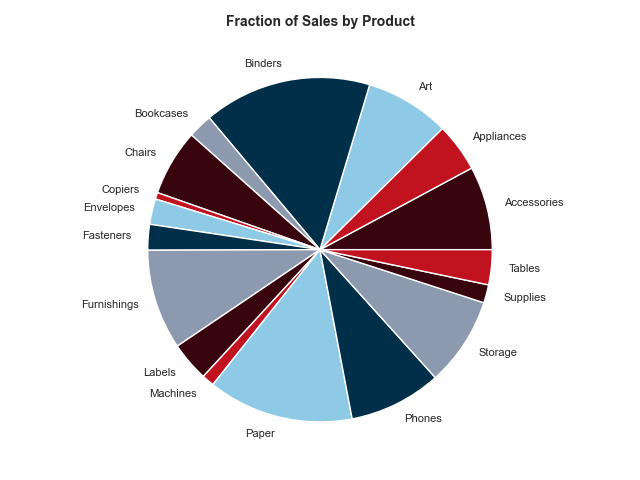

In [5]:
# Pie charts!
# df.groupby(['Sub-Category'])['Quantity'].aggregate('sum').plot(kind='pie', ylabel='')
fig, ax = plt.subplots()
ax.pie(df.groupby(['Sub-Category'])['Quantity'].aggregate('sum'), labels=df.groupby(['Sub-Category'])['Quantity'].aggregate('sum').index)
ax.set_ylabel=('')
ax.set_title('Fraction of Sales by Product', weight='bold')
plt.tight_layout()
plt.savefig("plots/pie.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

In [6]:
usa_cities = pd.read_csv('uscities.csv')
usa_cities = gpd.GeoDataFrame(usa_cities, geometry=gpd.points_from_xy(usa_cities.lng, usa_cities.lat))
usa_cities = usa_cities.query('state_id not in ["AK", "HI", "PR"]')

usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

df['City-State'] = df['City'] + '-' + df['State']
usa_cities['city'] = usa_cities['city'].replace({'New York': 'New York City'})
usa_cities['City-State'] = usa_cities['city'] +'-' + usa_cities['state_name']


city_sales = df.groupby(['City-State'], as_index=False).aggregate(({'Quantity': 'sum', 'State': 'first', 'City': 'first'}))
state_sales = df.groupby(['State'], as_index=False)['Quantity'].aggregate('sum')



result = usa_cities.set_index('City-State').join(city_sales.set_index('City-State'))
result_state = usa.set_index('state').join(state_sales.set_index('State'))


result = result.fillna(0) # to get rid of NaN values in quantity 
# len(result['city'].unique())
result = result[(result['Quantity'] > 0)]
# result = result[~result.index.duplicated(keep='first')]
result['Quantity'] = result['Quantity'].astype(int)

/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning

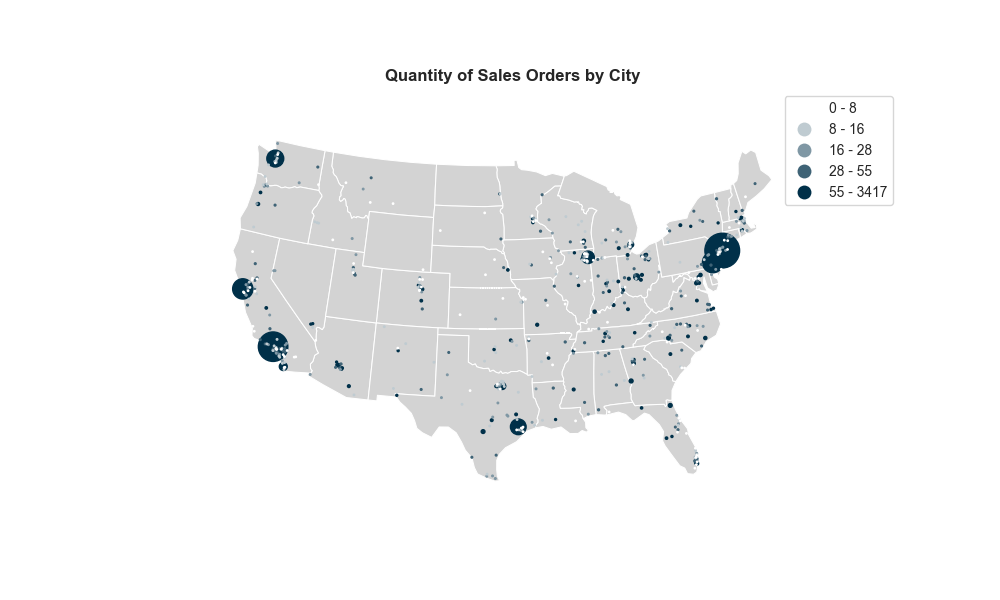

In [7]:
scheme = mc.Quantiles(result['Quantity'], k=5) # seven shades of color used 

# cartogram -- plots the sales based on state on a map! 
ax = gplt.polyplot(
    usa,
    projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
    linewidth=0.75,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(10, 6)
)

ax.set_title('Quantity of Sales Orders by City', fontsize=12, weight='bold')
gplt.pointplot(
    result, 
    limits=(1, 25),
    scale='Quantity',
    hue='Quantity',
    cmap=cmap_navy,
    scheme=scheme,
    legend=True,
    ax=ax
    )

plt.savefig("plots/map.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

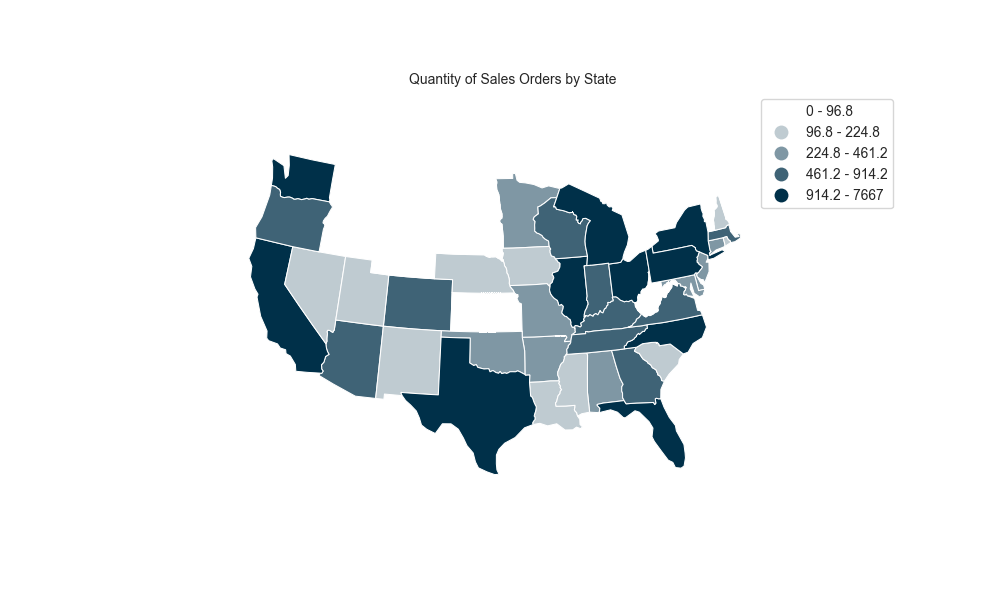

In [8]:
# now we graph by state 
state_scheme = mc.Quantiles(result_state['Quantity'], k=5) # seven shades of color used 


ax = gplt.choropleth(
    result_state,
    projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
    linewidth=0.75,
    hue='Quantity',
    cmap=cmap_navy,
    scheme=state_scheme,
    legend=True,
    figsize=(10, 6)
)

ax.set_title('Quantity of Sales Orders by State')
plt.savefig("plots/map.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning

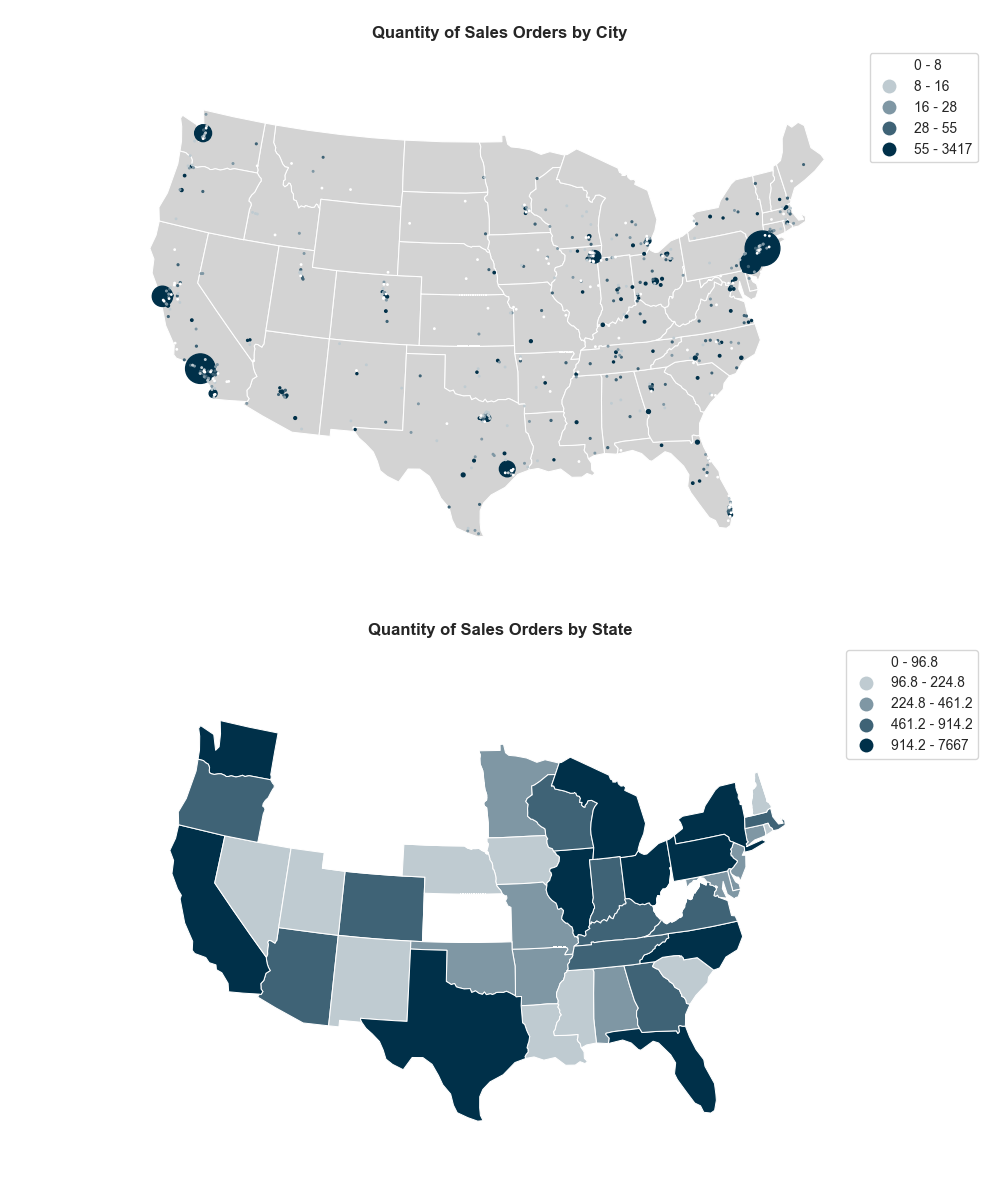

In [9]:
# plot with subplots 
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), subplot_kw={
    'projection': gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)})

scheme = mc.Quantiles(result['Quantity'], k=5) # seven shades of color used 

# cartogram -- plots the sales based on state on a map! 
ax1 = gplt.polyplot(
    usa,
    # projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
    linewidth=0.75,
    edgecolor='white',
    facecolor='lightgray',
    ax=axarr[0]
)

ax1.set_title('Quantity of Sales Orders by City', fontsize=12, weight='bold')
gplt.pointplot(
    result, 
    limits=(1, 25),
    scale='Quantity',
    hue='Quantity',
    cmap=cmap_navy,
    scheme=scheme,
    legend=True,
    ax=axarr[0]
    )

# now we graph by state 
state_scheme = mc.Quantiles(result_state['Quantity'], k=5) # seven shades of color used 


ax2 = gplt.choropleth(
    result_state,
    # projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
    linewidth=0.75,
    hue='Quantity',
    cmap=cmap_navy,
    scheme=state_scheme,
    legend=True,
    ax=axarr[1]
)

ax2.set_title('Quantity of Sales Orders by State', fontsize=12, weight='bold')
plt.tight_layout()
plt.savefig("plots/bothmaps.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

/var/folders/bz/ffk4_7b14dxf9m9bxxr_6xfw0000gn/T/ipykernel_74425/2032975236.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['Sub-Category'].unique(), rotation = 90)


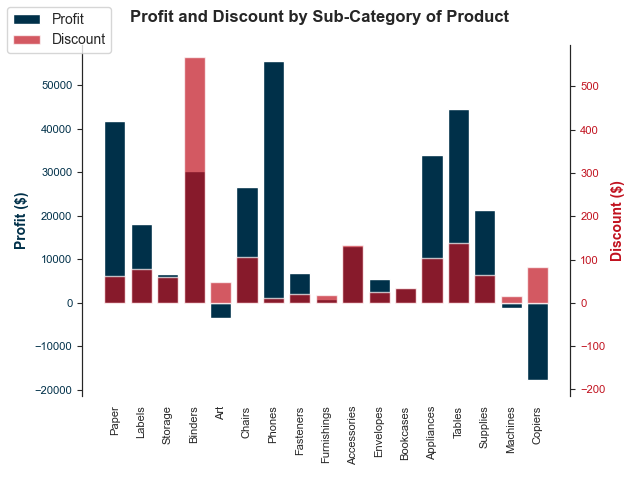

In [10]:
fig,ax = plt.subplots()

fig.suptitle('Profit and Discount by Sub-Category of Product', fontsize=12, weight='bold')
ax.bar(df['Sub-Category'].unique(), df.groupby('Sub-Category')['Profit'].aggregate('sum'), color=navy, alpha=1, label='Profit')
ax.tick_params(axis='y', labelcolor=navy)
ax.set_xticklabels(df['Sub-Category'].unique(), rotation = 90)
ax.set_ylabel('Profit ($)', color=navy)


ax2=ax.twinx()
ax2.bar(df['Sub-Category'].unique(), df.groupby('Sub-Category')['Discount'].aggregate('sum'), color=red, alpha=0.7, label='Discount')
ax2.set_ylabel('Discount ($)', rotation=90, color=red)
ax2.tick_params(axis='y', labelcolor=red)

fig.legend(loc='upper left')

ax1_ylims = ax.axes.get_ylim()           # Find y-axis limits set by the plotter
ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit

if ax1_yratio < ax2_yratio: 
    ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
else:
    ax.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)
    
sns.despine(top=True, bottom=True, right=False)
plt.tight_layout()
plt.savefig("plots/profdiscount.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

/var/folders/bz/ffk4_7b14dxf9m9bxxr_6xfw0000gn/T/ipykernel_74425/1373356225.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)


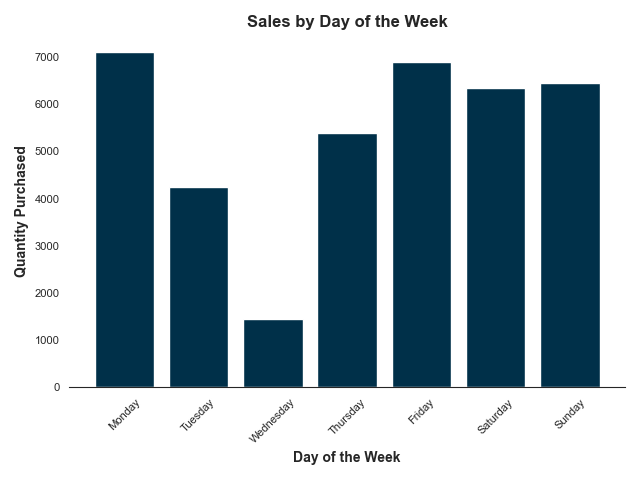

In [11]:
weekday_data = df.groupby('Weekday')['Quantity'].aggregate('sum')

fig,ax = plt.subplots()

ax.bar(weekday_data.index, weekday_data.values, color=navy)
ax.set_title('Sales by Day of the Week', fontsize=12, weight='bold')
ax.set_ylabel('Quantity Purchased')
ax.set_xlabel('Day of the Week')

ax.set_xticklabels(['Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
sns.despine(top=True, right=True, left=True)
plt.tight_layout()
plt.savefig("plots/doweek.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

## 2. Prophet

In [12]:
from prophet import Prophet

In [13]:
# series = df[(df['Sub-Category']=='Binders')].groupby('Order Date')['Quantity'].aggregate('sum')
series = df.groupby('Order Date')['Quantity'].aggregate('sum')
data = pd.DataFrame()
# data['ds'] = df[(df['Sub-Category']=='Binders')]['Order Date'].unique()
data['ds'] = weekly_data.index
data['y'] = weekly_data.values

TEST_SIZE = 52

train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]

train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [14]:
m = Prophet()
m.fit(train)

20:47:32 - cmdstanpy - INFO - Chain [1] start processing
20:47:32 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# create forecast
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from statsmodels.tools.eval_measures import rmse

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

predictions = forecast.iloc[-len(test):]['yhat']
actual = test['y']

print(f"RMSE: {round(rmse(predictions, actual))}")
plot_plotly(m, forecast)

RMSE: 173


In [16]:
plot_components_plotly(m, forecast)

/Users/kpomm/opt/anaconda3/envs/phys31/lib/python3.9/site-packages/plotly/io/_json.py:534: UserWarning:

Discarding nonzero nanoseconds in conversion.



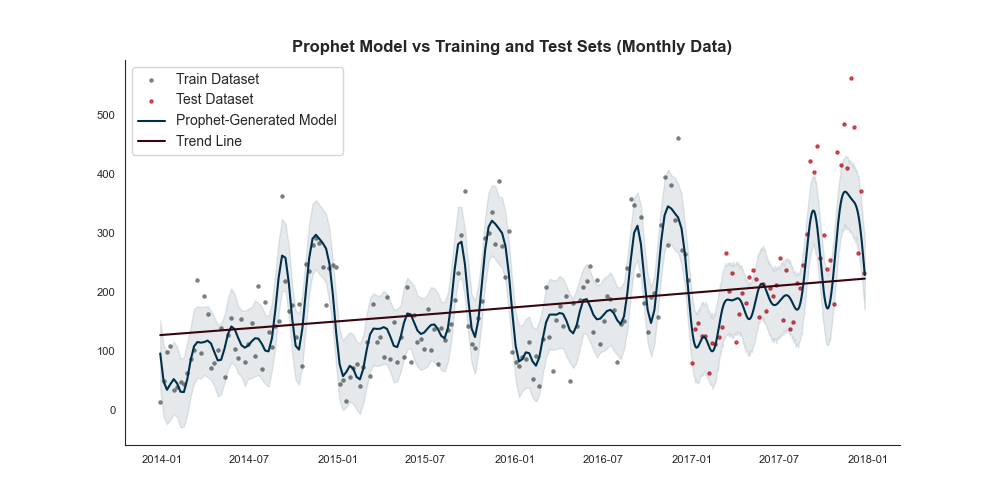

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title('Prophet Model vs Training and Test Sets (Monthly Data)', fontsize=12, weight='bold')
ax.scatter(train['ds'], train['y'], color='grey', s=5, alpha=1, label='Train Dataset')
ax.scatter(test['ds'], test['y'], color=red, s=5, alpha=0.7, label='Test Dataset')
ax.plot(forecast['ds'], forecast['yhat'], color=navy, label='Prophet-Generated Model')
ax.plot(forecast['ds'], forecast['trend'], color=darkred, label='Trend Line')
ax.legend(loc='upper left')
sns.despine(top=True, right=True)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color=navy, alpha=0.1)
plt.savefig("plots/modelvtraining-month.png", format="png", bbox_inches='tight', dpi=1200)
plt.show()

## 3. Archives

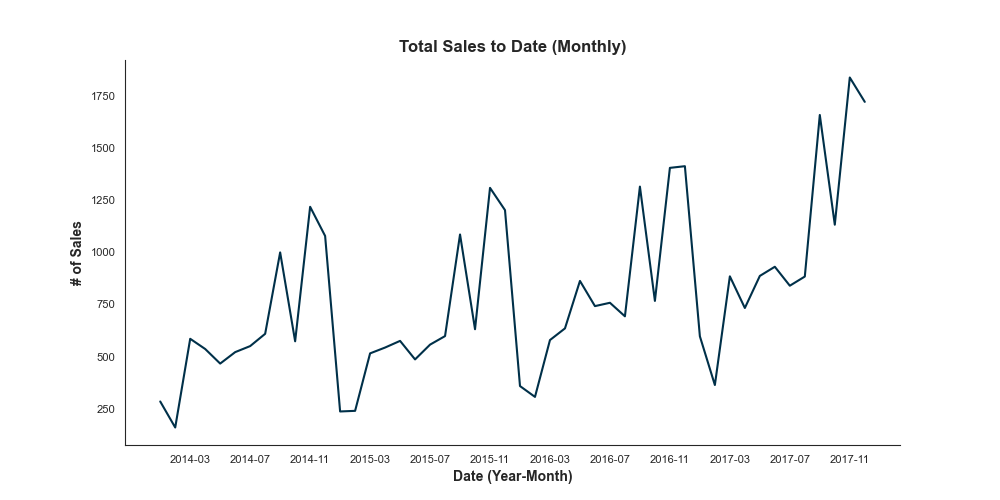

In [18]:
# All sales plotted
plt.figure(figsize=(10, 5))
plt.plot(df['Order Year-Month'].unique(), df.groupby('Order Year-Month')['Quantity'].aggregate('sum'), label='All Sales', color=navy)  

# set an x tick every 9 months 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.title('Total Sales to Date (Monthly)', fontsize=12, weight='bold')
plt.xlabel('Date (Year-Month)') 
# plt.xticks(rotation=90)
plt.ylabel('# of Sales') 
sns.despine(top=True, right=True)

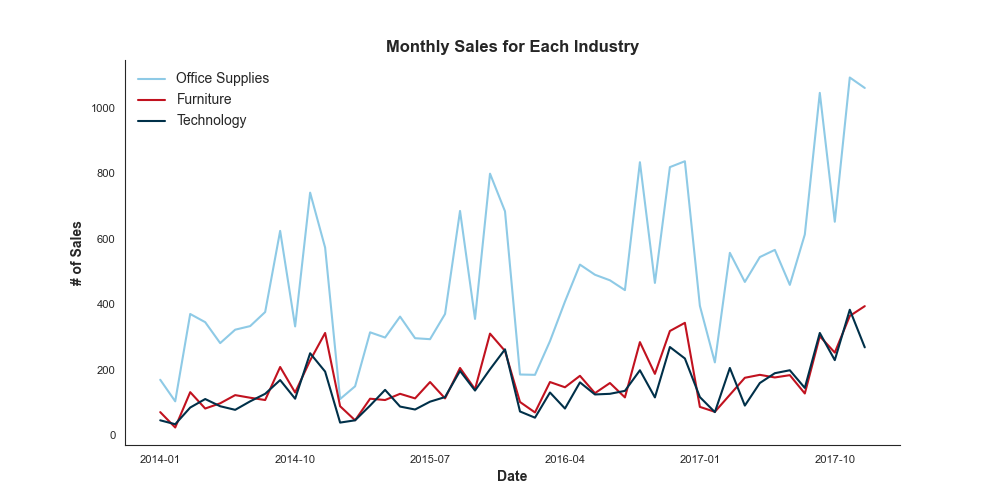

In [19]:
# Sales by Industry
plt.figure(figsize=(10, 5))
plt.plot(df[(df['Category']=='Office Supplies')]['Order Year-Month'].unique(), df[(df['Category']=='Office Supplies')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=lightblue, label='Office Supplies') 
plt.plot(df[(df['Category']=='Furniture')]['Order Year-Month'].unique(), df[(df['Category']=='Furniture')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=red, label='Furniture') 
plt.plot(df[(df['Category']=='Technology')]['Order Year-Month'].unique(), df[(df['Category']=='Technology')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=navy, label='Technology') 

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

plt.title('Monthly Sales for Each Industry', fontsize=12, weight='bold')
plt.xlabel('Date') 
plt.ylabel('# of Sales') 
plt.legend(loc='upper left')
sns.despine(top=True, right=True)
plt.legend(frameon=False)


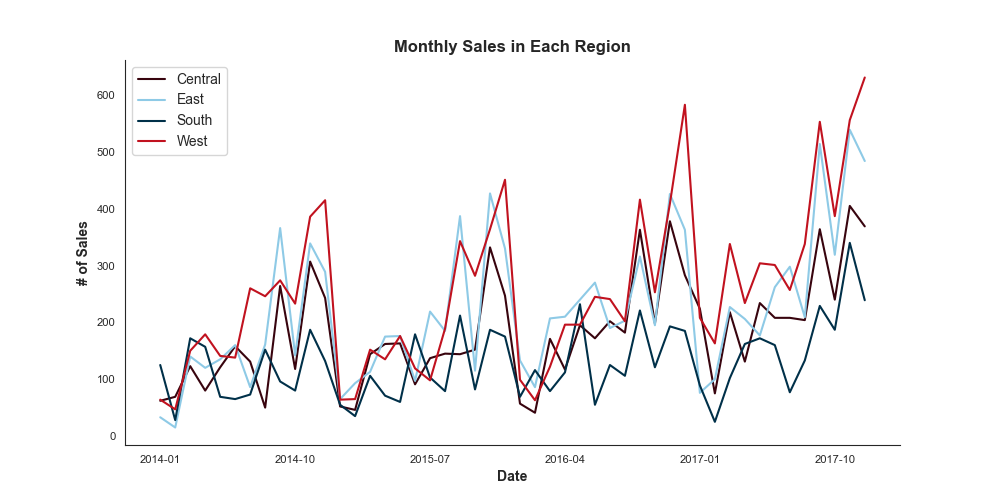

In [20]:
# Sales by Region
plt.figure(figsize=(10, 5))

plt.plot(df[(df['Region']=='Central')]['Order Year-Month'].unique(), df[(df['Region']=='Central')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=darkred, label='Central') 
plt.plot(df[(df['Region']=='East')]['Order Year-Month'].unique(), df[(df['Region']=='East')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=lightblue, label='East')  
plt.plot(df[(df['Region']=='South')]['Order Year-Month'].unique(), df[(df['Region']=='South')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=navy, label='South')   
plt.plot(df[(df['Region']=='West')]['Order Year-Month'].unique(), df[(df['Region']=='West')].groupby('Order Year-Month')['Quantity'].aggregate('sum'), color=red, label='West') 

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

plt.title('Monthly Sales in Each Region', fontsize=12, weight='bold' )
plt.xlabel('Date') 
plt.ylabel('# of Sales') 
plt.legend(loc='upper left')
# plt.grid(alpha=.4)
sns.despine(top=True, right=True)